# ACDC 2022 - ERA5 Exploration Jupyter Notebook
#### M. M. Lague; Aug. 2022

Loads and plots some ERA5 data on a laptop

-----

Load a bunch of packages that we might use

In [50]:
%matplotlib inline
import sys
sys.path.append('./scripts')

# netcdf/numpy/xarray
import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr
from scipy import interpolate
from numpy import ma
from scipy import stats
import scipy.io as sio
import pickle as pickle
from sklearn import linear_model
import numpy.ma as ma
import matplotlib.patches as mpatches

import scipy as sp
import pandas as pd

import time

from copy import copy 

#from joblib import Parallel, delayed
import multiprocessing
import dask
import dask.bag as db

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker

from matplotlib.ticker import FormatStrFormatter

from matplotlib import gridspec

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point



# OS interaction
import os
import sys
import cftime
import datetime

import glob



from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)


# from windspharm.standard import VectorWind
# import spharm

## Define a few functions for plotting that we might want to use later

In [46]:
violet = np.array([207,156,255])/255
fushia = np.array([209, 20, 232])/255
peri = np.array([71,168,237])/255

# make a new local mapping function that doesn't use basemap

def quick_map(mapdata,lat,lon,title=None,cb_ttl=None,cmap=None,clim=None,
              filepath=None,show=None,sigmask=None,p=None,
              do_zonal=None,
              outside_color = None, outside_val = None):
    
    if do_zonal==1:
        # make 2 subplots, one for map, one for zonal average next to it
        fig = plt.figure(figsize=(8,7))
    else:
        fig = plt.figure(figsize=(8,7))
    
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

    #cs = plt.contourf(cyclic_lons,lat,cyclic_data,60,transform=ccrs.PlateCarree(),extend='both')#,vmin=clim[0],vmax=clim[1])
    cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
    

    if cmap:
        plt.set_cmap(copy(cmap))
    else:
        plt.set_cmap(copy(plt.cm.viridis))
    
#     cmap = plt.get_cmap()
#     cmap.set_bad(color='black')
   
    
    if title:
        plt.title(title,fontsize=16,y=1.05)
        
    if clim:
        plt.cm.ScalarMappable.set_clim(cs,vmin = clim[0],vmax = clim[1])
#         plt.clim(clim)  
#         cs.set_clim(clim[0],clim[1])
#         cs.set_clim(clim)
        
    cbar = plt.colorbar(ax=ax,orientation='horizontal',extend='both',pad=.02, shrink=0.9)
    cbar.ax.tick_params(labelsize=14) 
    
#     if clim:
#         cbar.set_clim(clim)

    if cb_ttl:
        cbar.set_label(cb_ttl,fontsize=14)
    
#     # If outside_val and outside_color, check if pos (set_over) or neg (set_under) to outside_color:
#     if outside_val:
#         cm = plt.get_cmap()
#         if outside_val=='left':
#             cm.set_under(color=outside_color)
#         elif outside_val=='right':
#             cm.set_over(color=outside_color)
#         else:
#             a=9# garbarge filler...
#     else:
#         cm=0.0
    cm = plt.get_cmap()
   
    # add hatching for significance
    if p:
        cyclic_sig, cyclic_lons = add_cyclic_point(sigmask,coord=lon)
        #hatch = plt.pcolor(cyclic_lons,lat,cyclic_sig,hatch='xxx',alpha=0.,transform=ccrs.PlateCarree()); 

        CLN, CLT = np.meshgrid(cyclic_lons,lat)

        # only put the hatches where the sigmask is >0.5
        #cyclic_sig = np.ma.masked_where(cyclic_sig<p,cyclic_sig)
        sigmask = np.where(cyclic_sig>p,1.0,np.nan)
        sigmask2 = np.ma.masked_where(cyclic_sig > p, sigmask)
        
        lat_sig = np.ma.masked_where(cyclic_sig>p,CLT)
        lat_sig = np.ma.masked_where(np.isnan(cyclic_sig),lat_sig)
        lon_sig = np.ma.masked_where(cyclic_sig>p,CLN)
        lon_sig = np.ma.masked_where(np.isnan(cyclic_sig),lon_sig)

        hatch = ax.scatter(lon_sig,lat_sig,s=sigmask2,marker='x',#s=2,
                           c=[0.6, 0.6, 0.6],alpha=0.8,transform=ccrs.PlateCarree(),)

    ax.patch.set_alpha(0.0)
    
    if show:
        plt.show()
    
    if filepath:
        # save figure if path given
        fig.savefig(filepath+'.png',dpi=300,facecolor=None,edgecolor=None,bbox_inches='tight',transparent=True,pad_inches=0.01)
        
    plt.close()
    
    return fig,ax,cs,cbar,cm



      

----

## Link external harddrive
At least for me, my local jupyterlab session won't access data on an external drive unless I create a symbolic link from somewhere the session *can* access - I'm putting it in the same place as this notebook.

`ln -s /Volumes/OneTouch/ACDC/ERA5_ACDC/ /Users/mlague/Documents/ACDC/ERA5_ACDC`


----

### Load a bunch of ERA5 data from an external drive


In [20]:
era5_path = '/Users/mlague/Documents/ACDC/ERA5_ACDC/variables/raw/'

list what surface (or non-vertical) variables we'd like, and what vertical variables we'd like. I do this separately because the vertical ones are a lot bigger, so it is a quick thing to comment out if I don't want to load vertically resolved stuff.

The ERA5 data is pretty high resolution, so the files are ALL kind of big. Xarray and dask should "lazy" load the data we ask for - it won't actually read it into memory until we try and do some math or plotting with it. 

In [38]:
sfc_varlist = ['2m_temperature','skin_temperature',]
               # 'surface_latent_heat_flux','surface_sensible_heat_flux',
               # 'surface_net_solar_radiation','surface_net_thermal_radiation',
               # 'surface_solar_radiation_downwards','surface_thermal_radiation_downwards']
vert_varlist = ['temperature']

In [43]:

filelist = []

for var in sfc_varlist + vert_varlist:
    
    print(var)
    
    # get ALL the files in the variable's directory. You can be more fancy and only load a restricted time period. 

    files_temp = sorted( filter( os.path.isfile,
                        glob.glob(era5_path + var + '/*.nc') ) )
    
    filelist = filelist + files_temp
    
    del files_temp

# print(len(filelist))
# print(filelist)

2m_temperature
skin_temperature
temperature


In [71]:
ds_all = xr.open_mfdataset(filelist)


Frozen({'longitude': <xarray.IndexVariable 'longitude' (longitude: 1440)>
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02], dtype=float32)
Attributes:
    units:      degrees_east
    long_name:  longitude, 'latitude': <xarray.IndexVariable 'latitude' (latitude: 721)>
array([ 90.  ,  89.75,  89.5 , ..., -89.5 , -89.75, -90.  ], dtype=float32)
Attributes:
    units:      degrees_north
    long_name:  latitude, 'time': <xarray.IndexVariable 'time' (time: 756)>
array(['1959-01-01T00:00:00.000000000', '1959-02-01T00:00:00.000000000',
       '1959-03-01T00:00:00.000000000', ..., '2021-10-01T00:00:00.000000000',
       '2021-11-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:  time, 'skt': <xarray.Variable (time: 756, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(756, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Attributes:
    units: 

## Plot something

Like a map of the 2020 - 1959 surface temperature

Note: the coastlines won't show up if you're running offline if the coastline file for cartopy isn't downloaded somewhere already

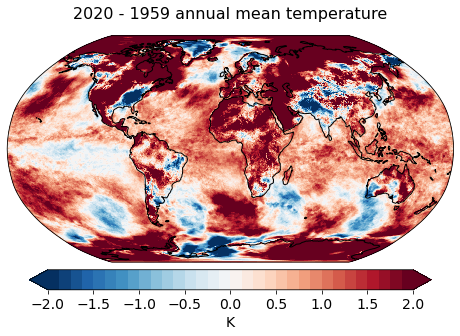

In [73]:
var = 't2m'

mapdata = ( ds_all[var].sel(time=slice('2020-01-01', '2020-12-31')).mean('time') - 
       ds_all[var].sel(time=slice('1959-01-01', '1959-12-31')).mean('time') )

lat = mapdata.latitude
lon = mapdata.longitude

fig = plt.figure(figsize=(8,7))


ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(linewidth=2) 
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

title='2020 - 1959 annual mean temperature'
cb_ttl='K'
cmap=plt.cm.get_cmap('RdBu_r',32)
clim=[-2,2]

cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())


plt.set_cmap(copy(cmap))

plt.title(title,fontsize=16,y=1.05)

plt.cm.ScalarMappable.set_clim(cs,vmin = clim[0],vmax = clim[1])

cbar = plt.colorbar(ax=ax,orientation='horizontal',extend='both',pad=.02, shrink=0.9)
cbar.ax.tick_params(labelsize=14) 

cbar.set_label(cb_ttl,fontsize=14)


ax.coastlines() 

plt.show()

plt.close()